In [1]:
import xarray as xr
import numpy

from scipy.signal import convolve2d
from scipy.ndimage import measurements
from skimage.morphology import reconstruction

import matplotlib.pyplot as plt

import holoviews as hv
import hvplot.xarray

In [2]:
ds_runoff = xr.open_dataset('~/Downloads/WESLEY/runoff_60Ma.nc')
ds_runoff

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    rtm      (lat, lon) float64 ...
    topo     (lat, lon) float64 ...
    cmsk     (lat, lon) int32 ...

In [3]:
ds = xr.open_dataset('~/Downloads/WESLEY/60Ma_bil_netcdf-editor.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    topo     (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.7.2 (http://mpimet.mpg.de/...
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdconvert
    description:  Grid reconstructed using R[lon lat omega] = 125.3 0 17.1
    GMT_version:  5.4.4 (r20314) [64-bit] [MP]
    CDO:          Climate Data Operators version 1.7.2rc6 (http://mpimet.mpg....
    history:      Wed Dec  2 12:36:59 2020: ncrename -v z,topo 60Ma_bil.nc\nW...
    NCO:          "4.6.0"

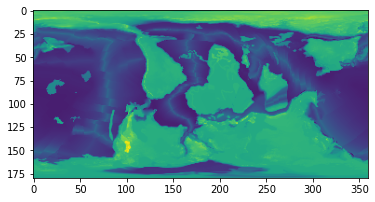

In [4]:
def fill_depressions_in_topo(dem):
        seed = numpy.copy(dem)
        # Add borders
        seed[1:-1, 1:-1] = dem.max()

        filled = reconstruction(seed, dem, method='erosion')
        # Reset the ocean -> dont modify the ocean
        filled[dem <= 0] = dem[dem <= 0]
        return filled
    
topo = fill_depressions_in_topo(ds.topo.values)
plt.imshow(topo)

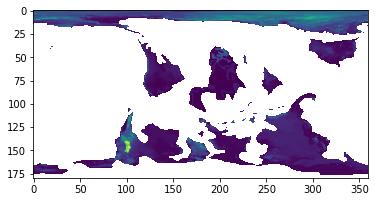

In [5]:
orog = topo.copy()
orog[orog <= 0] = numpy.nan
plt.imshow(orog)

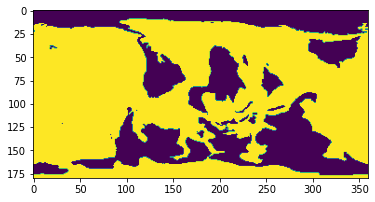

In [6]:
omsk = numpy.zeros(topo.shape)
omsk[numpy.isnan(orog)] = 1
plt.imshow(omsk)

In [7]:
def get_adjacent_coords(i, j, arr):
    imax, jmax = arr.shape
    if j == jmax - 1:
        jp1 = 0
    else:
        jp1 = j + 1
    if j == 0:
        jm1 = jmax - 1
    else:
        jm1 = j - 1
        
    ip1 = numpy.min((i + 1, imax - 1))
    im1 = numpy.max((0, i - 1))
    
    return numpy.array(numpy.meshgrid([im1, i, ip1], [jm1, j, jp1], indexing='ij')).reshape(2, -1).T

def get_adjacent_values(i, j, arr):
    return numpy.array([arr[ii,jj] for ii,jj in get_adjacent_coords(i,j, arr)]).reshape(3, -1)

In [8]:
def get_padded_array(arr):
    # Add a pad of 1 around the edge and use the wrap method
    padded = numpy.pad(arr, 1, 'wrap')
    # Fix the Top and bottom because they are the same value as before and not wrapped
    padded[0] = padded[1]
    padded[-1] = padded[-2]
    return padded

def calculate_cmsk():
    template = numpy.ones(9).reshape(3,3)
    # pad the array so we don't have to worry about edge cases
    is_water = get_padded_array(omsk).astype(bool)
    # Calculate the convolution
    conv = convolve2d(is_water, template, 'same')
    # Extract the values we want
    # Conv is positive where one of the adjacent cells is ocean
    # We only want land cells
    res = (conv > 0) & (~is_water)
    # We padded omsk so as to not worry about the periodicity
    # Now we have to remove the padding
    res = res[1:-1, 1:-1]
    return res

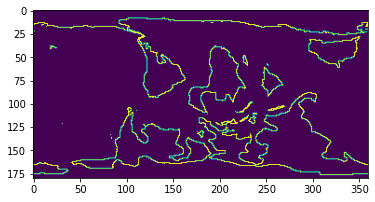

In [9]:
cmsk = calculate_cmsk()
plt.imshow(cmsk)

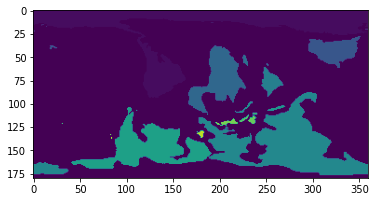

In [10]:
def calculate_continents():
    # Calculate the continents measurements returns a list of distinct objects in the image
    continents = measurements.label(~omsk.astype(bool))[0]
    # Take a look at the edges and see where continents are different and should be the same due to cyclicite
    difference_long_180 = numpy.argwhere((continents[:, 0] != continents[:, -1]) & # Check first column and last column are the same
                           (continents[:, 0] != 0) & # Make sure the first column isn't ocean -> last column is a coast
                           (continents[:, -1] != 0) # Make sure the last column isn't ocean -> first column is a coast
                          ).flatten()
    same_continents = []
    for d in difference_long_180:
        vals = [continents[d, 0], continents[d, -1]]
        inserted = False
        for i in range(len(same_continents)):
            conts = same_continents[i]
            # At least one of the values already exists in a list
            if len(set(vals) & set(conts)):
                conts.extend(vals)
                same_continents[i] = list(set(conts))
                inserted = True
                break
        # If the continents haven't already been seen then add a new continent to the list
        if not inserted:
            same_continents.append(vals)

    for cont in same_continents:
        # Replace all values in continents with the first value
        for i in range(1, len(cont)):
            continents[continents == cont[i]] = cont[0]
    return continents

continents = calculate_continents()
plt.imshow(continents)

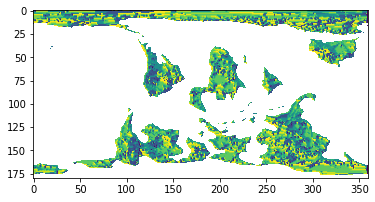

In [11]:
def calculate_rtm_slow():
    rtm_values = numpy.array([6, 5, 4, 7, 0, 3, 8, 1, 2])
    padded_topo = get_padded_array(topo)
    rtm = numpy.empty(topo.shape)
    for i in range(1, topo.shape[0]):
        for j in range(1, topo.shape[1]):
            rtm[i-1,j-1] = rtm_values[numpy.argmin(get_adjacent_values(i, j, padded_topo))]
    return numpy.where(omsk == False, rtm, numpy.nan)

rtm_slow = calculate_rtm_slow()
plt.imshow(rtm_slow)

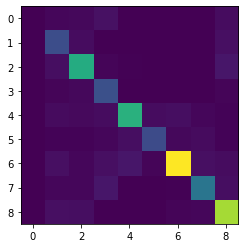

In [12]:
vals = numpy.array([rtm_slow.flatten(), ds_runoff.rtm.values.flatten()]).T
vals[numpy.isnan(vals)] = -1
vals = vals.astype(int)

binned = numpy.zeros((10,10))
for ij in vals:
    i, j = ij
    i +=1
    j +=1
    binned[i, j] += 1
    
plt.imshow(binned[1:, 1:])

# Quicker way of calculating rtm using arrays

<div class='alert alert-danger'>
There seems to be a small bug here still
</div>

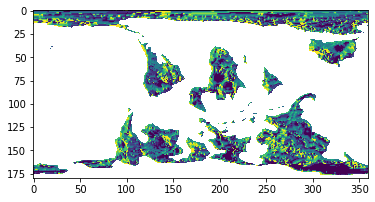

In [13]:
def calculate_rtm():
    arr = get_padded_array(topo)
    NS = (arr[1:] - arr[:-1])
    EW = (arr[:, :-1] - arr[:, 1:])
    SENW = arr[1:, 1:] - arr[:-1, :-1] 
    NESW = arr[1:, :-1] - arr[:-1, 1:]
    arrays = numpy.array([
                            NS[1:, 1:-1] * -1 ,
                            SENW[1:, 1:] * -1,   
                            EW[1:-1, 1:], 
                            NESW[:-1, 1:],
                            NS[:-1, 1:-1],
                            SENW[:-1, :-1],
                            EW[1:-1, :-1] * -1,
                            NESW[1:, :-1] * -1,
                          ])

    ind = numpy.argmax(arrays, axis=0) 
    ind += 1
    a1,a2=numpy.indices(ind.shape)
    rtm = ind.astype(float)
    rtm[omsk == True] = numpy.nan
    return rtm

rtm = calculate_rtm()
plt.imshow(rtm)

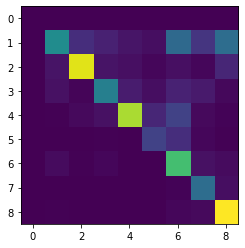

In [14]:
vals = numpy.array([rtm.flatten(), ds_runoff.rtm.values.flatten()]).T
vals[numpy.isnan(vals)] = -1
vals = vals.astype(int)

binned = numpy.zeros((10,10))
for ij in vals:
    i, j = ij
    i +=1
    j +=1
    binned[i, j] += 1
    
plt.imshow(binned[1:, 1:])

In [15]:
bad = []
idx = [7, 6, 3, 0, 1, 2, 5, 8]
for coords in numpy.argwhere((rtm != ds_runoff.rtm.values) & (omsk != True)):
    
    i, j = coords
    arr = get_adjacent_values(i, j, topo)
    if not arr.flatten()[idx][int(rtm[i, j])-1] == arr.flatten()[idx][int(ds_runoff.rtm.values[i, j]) - 1]:
        bad.append((i, j))